## 1. Load Libraries

In [ ]:
# Uncomment if the libraries are not already installed to machine
# !pip install --upgrade mxnet
# !pip install autogluon
import os
import pandas as pd
import sys
import numpy as np
from google.colab import drive
from scipy.spatial.transform import Rotation as R
import autogluon as ag
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report

# Mount drive in order to retrieve data
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Load Data
NOTE: full_data.csv is a combined csv of all of our shot data.

In [ ]:
# Load data from combined .csv file of all Brekel Body Data for local positions and rotations
full_data = pd.read_csv("/content/drive/My Drive/Senior Design C41/full_data.csv")
full_data = full_data.drop('Unnamed: 0',axis=1)

# Load data from combined .csv file of all Brekel Body Data for absolute positions
abs_full_data = pd.read_csv("/content/drive/My Drive/Senior Design C41/absolute_full_data.csv")
abs_full_data = abs_full_data.drop('Unnamed: 0',axis=1)

# Combine the two csvs
full_data = pd.concat([abs_full_data,full_data[full_data.columns[[~full_data.columns.isin(['person','class','shot'])]]]],axis=1)

# Drop NaN values
full_data = full_data.dropna().reset_index().drop(['index'],axis=1)
# Uncomment below to see dataframe
# full_data

In [ ]:
# compare_df is a dataframe trying to get the indexes of each shot's data
# along with the person, class, and shot of that data.
compare_df = full_data[['person','class','shot']].drop_duplicates() # Must drop duplicates so that compare_df doesn't have 180 instances of every shot

# Separate dataframe into 3 different dataframes per person
justin_compare_df = compare_df[compare_df.person=='Justin']
brendan_compare_df = compare_df[compare_df.person=='Brendan']
carl_compare_df = compare_df[compare_df.person=='Carl']

# Separate each person's dataframe into successful and failed shots
justin_1=justin_compare_df[justin_compare_df['class']==1]['shot'].values
justin_0=justin_compare_df[justin_compare_df['class']==0]['shot'].values
brendan_1=brendan_compare_df[brendan_compare_df['class']==1]['shot'].values
brendan_0=brendan_compare_df[brendan_compare_df['class']==0]['shot'].values
carl_1=carl_compare_df[carl_compare_df['class']==1]['shot'].values
carl_0=carl_compare_df[carl_compare_df['class']==0]['shot'].values

# Shuffle each person's data
np.random.shuffle(justin_1)
np.random.shuffle(justin_0)
np.random.shuffle(brendan_1)
np.random.shuffle(brendan_0)
np.random.shuffle(carl_1)
np.random.shuffle(carl_0)

## 3. Data Preprocessing
* The data collected from Brekel is not uniform. Some data is 180 rows, others are 178 rows. Thus, we have to establish uniformity among the row length of all data.
* Also, we want to reshape the data such that each row of the dataframe is shot indexed rather than timestamp indexed. In other words, each row is shot 0 rather than each row being timestamp 0 of shot 0.

In [ ]:
# Get the sizes of all the csv files
uniques = np.unique(abs_full_data['shot'])
for x in uniques:
    csv_lengths.append(len(abs_full_data[abs_full_data['shot']==x]))

temp_arr1 = np.array(csv_lengths)
temp_arr1 = temp_arr1[temp_arr1>170]
temp_arr1 = temp_arr1[temp_arr1<200]

Text(0, 0.5, 'Frequency')

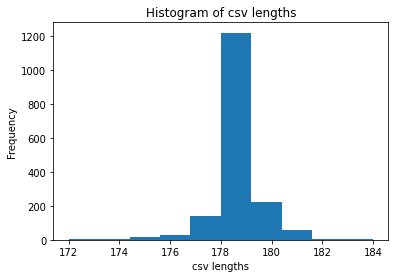

In [ ]:
# Visualize the frequency of csv lengths to determine the lowest possible threshold
plt.hist(temp_arr1)
plt.title('Histogram of csv lengths')
plt.xlabel('csv lengths')
plt.ylabel('Frequency')

In [ ]:
"""
IDENTIFY WHICH SHOTS WE NEED TO NORMALIZE ROW LENGTH FOR
"""
# Create a dictionary with every shot in the data as the indexes
shot_dict={}

# Loop to get the length of every shot
for i in range(1,len(np.unique(full_data['shot']))+1):
    length=len(full_data[full_data['shot']==i])
    shot_dict[i] = length

shot_dict_thres = dict((k, v) for k, v in shot_dict.items() if v >= 170) # Place shot_dict list in dictionary form
shot_fix = [k for k, v in shot_dict.items() if v >= 176] # Looking for all shots >= 176 rows

In [ ]:
"""
GO THROUGH ALL THE DATA.
FIRST, NORMALIZE THE ROW LENGTH.
SECOND, RESHAPE DATA SUCH THAT EACH ROW REPRESENTS A SHOT AND THERE EXIST COLUMNS
TO REPRESENT A FEATURE'S VALUE AT A PARTICULAR FRAME
Expected Runtime: About 15 Minutes
"""
# flatten_df is the converted full_data dataframe in which each column's row data is a separate column.
#   i.e: Waist_local_position_X[48] is now column 'Waist_local_position_X_48'
flatten_df = pd.DataFrame()
for i in range(0,len(shot_fix)):
  # Dataframe of the current shot iteration
  focus_df = full_data[full_data['shot']==shot_fix[i]]

  # Normalize row size to 176 rows
  if len(focus_df)>176:
      focus_df = focus_df.iloc[:176,:]

  # feature_names is used to create column name in flattened dataframe
  feature_names = np.array(focus_df.drop(columns=['timestamp','person','class','shot']).columns)

  # In a loop, get the row data of a feature and create a column name of that feature
  flatten_feature = np.array([])
  for j in range(len(focus_df)):
      flatten_feature = np.append(flatten_feature, np.array([feature_names + '_' + str(j)]))

  # Place data into a combined, flattened dataframe
  one_flatten_df = pd.DataFrame([focus_df[feature_names].values.flatten()], columns=flatten_feature)
  flatten_df = pd.concat([flatten_df,one_flatten_df])

In [ ]:
# Uncomment to see flatten_df
flatten_df

,Waist_local_position_X_0,Waist_local_position_Y_0,Waist_local_position_Z_0,Waist_local_rotation_X_0,Waist_local_rotation_Y_0,Waist_local_rotation_Z_0,Spine_local_position_X_0,Spine_local_position_Y_0,Spine_local_position_Z_0,Spine_local_rotation_X_0,...,Hand R_local_position_Z_175,Hand R_local_rotation_X_175,Hand R_local_rotation_Y_175,Hand R_local_rotation_Z_175,FingerTips R_local_position_X_175,FingerTips R_local_position_Y_175,FingerTips R_local_position_Z_175,FingerTips R_local_rotation_X_175,FingerTips R_local_rotation_Y_175,FingerTips R_local_rotation_Z_175
0,0.762604,1.061696,-0.044270,0.0,0.0,0.0,0.0,0.127115,0.0,0.0,...,-0.0,-25.202230,-37.466045,28.990526,-0.150944,-0.0,0.0,0.0,0.0,0.0
0,0.666845,1.048362,-0.136568,0.0,0.0,0.0,-0.0,0.127624,-0.0,0.0,...,0.0,336.158844,-10.206134,-337.129639,-0.162753,-0.0,-0.0,0.0,0.0,0.0
0,0.628887,1.014375,-0.149530,0.0,0.0,0.0,-0.0,0.136075,-0.0,0.0,...,0.0,-375.489990,-1.775908,19.847477,-0.159485,-0.0,0.0,0.0,0.0,0.0
0,0.684368,1.002358,-0.104537,0.0,0.0,0.0,0.0,0.137680,-0.0,0.0,...,0.0,-29.808489,-5.708731,30.853426,-0.161048,-0.0,-0.0,0.0,0.0,0.0
0,0.742596,0.977850,-0.047554,0.0,0.0,0.0,0.0,0.152140,-0.0,0.0,...,-0.0,-399.824921,-7.997807,27.813227,-0.169846,0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.393836,0.970577,0.487607,0.0,0.0,0.0,0.0,0.132742,-0.0,0.0,...,0.0,-361.197205,12.037156,4.416232,-0.144045,-0.0,-0.0,0.0,0.0,0.0
0,0.421431,0.981848,0.460335,0.0,0.0,0.0,-0.0,0.132742,-0.0,0.0,...,-0.0,-358.722046,13.442245,1.055166,-0.141246,-0.0,0.0,0.0,0.0,0.0
0,0.430533,0.986372,0.478094,0.0,0.0,0.0,-0.0,0.131603,0.0,0.0,...,-0.0,1.887533,3.381482,4.638025,-0.156446,-0.0,-0.0,0.0,0.0,0.0
0,0.398045,0.974103,0.472718,0.0,0.0,0.0,-0.0,0.132742,0.0,0.0,...,-0.0,3.748029,-22.311562,-2.062577,-0.151036,-0.0,0.0,0.0,0.0,0.0


In [ ]:
"""
REAPPEND SHOT IDENTIFYING FEATURES TO NEW DATAFRAME
"""
# Creating a list for every shot identifying feature
#   class: successful / failed shot
#   shot: Index of the shot
#   person: Who shot the free throw
class_id_list = []
shot_id_list = []
person_id_list = []

# Loop to get every shot and place features into their respectful list
for i in range(0,len(shot_fix)):
  focus_df = full_data[full_data['shot']==shot_fix[i]]
  class_id_list.append(np.unique(focus_df['class'])[0])
  shot_id_list.append(np.unique(focus_df['shot'])[0])
  person_id_list.append(np.unique(focus_df['person'])[0])

# Reappend the shot identifying features to flattened dataframe (class, person, shot)
flatten_df['class']=class_id_list
flatten_df['person']=person_id_list
flatten_df['shot']=shot_id_list

# Fix Dataframe indexes (Prior to this code, dataframe index for all rows is 0)
flatten_df=flatten_df.reset_index().drop('index',axis=1)

# Save to drive
flatten_df.to_csv("/content/drive/My Drive/Senior Design C41/flatten_df1.csv")

In [ ]:
# Load from drive if already created flattened csv
flatten_df = pd.read_csv("/content/drive/My Drive/Senior Design C41/flatten_df1.csv")
flatten_df = flatten_df.drop('Unnamed: 0', axis=1)

## 4. Generate Train/Test Split

In [ ]:
"""
Function to get the train/test split for a single person
  Inputs: Successful and Failed Shot Dataframes
  Outputs: Train and Test Split Dataframes
"""
def get_subject_splits(fail_label_arr,success_label_arr):
  test_size = 0.2 # 80% Train, 20% Test
  fail_train_size = int(len(fail_label_arr) * (1 - test_size))
  success_train_size = int(len(success_label_arr) * (1 - test_size))

  fail_test_size = len(fail_label_arr) - fail_train_size
  success_test_size = len(success_label_arr) - success_train_size

  train_split = []
  test_split = []

  for i in range(0,5):
    fail_section_start = fail_test_size*i
    success_section_start = success_test_size*i
    fail_section_end = fail_test_size*(i+1)
    success_section_end = success_test_size*(i+1)

    fail_test = fail_label_arr[fail_section_start:fail_section_end]
    success_test = success_label_arr[success_section_start:success_section_end]
    fail_train = np.setxor1d(fail_test, fail_label_arr)
    success_train = np.setxor1d(success_test, success_label_arr)

    train_split.append(np.concatenate((fail_train, success_train),axis=None))
    test_split.append(np.concatenate((fail_test, success_test),axis=None))

  return train_split, test_split

In [ ]:
"""
Function to combine all person's splits or focus on individual people into a single train/test split
Depends on get_subject_splits
  Inputs: flatten_df Dataframe and people
  Output: Train dataframe, Test dataframe
"""
def get_all_splits(df,mode):
    justin_train, justin_test = get_subject_splits(justin_0,justin_1)
    brendan_train, brendan_test = get_subject_splits(brendan_0,brendan_1)
    carl_train, carl_test = get_subject_splits(carl_0,carl_1)

    train_split = []
    test_split = []
    for i in range(0,5):
        if mode=='all':
            train_indices = np.concatenate((justin_train[i], brendan_train[i], carl_train[i]))
            test_indices = np.concatenate((justin_test[i], brendan_test[i], carl_test[i]))
            train_split.append(df[df['shot'].isin(train_indices)].drop(['person','shot'],axis=1))
            test_split.append(df[df['shot'].isin(test_indices)].drop(['person','shot'],axis=1))
        elif mode=='carl':
            train_indices = carl_train[i]
            test_indices = carl_test[i]
            train_split.append(df[df['shot'].isin(train_indices)].drop(['person','shot'],axis=1))
            test_split.append(df[df['shot'].isin(test_indices)].drop(['person','shot'],axis=1))
        elif mode=='brendan':
            train_indices = brendan_train[i]
            test_indices = brendan_test[i]
            train_split.append(df[df['shot'].isin(train_indices)].drop(['person','shot'],axis=1))
            test_split.append(df[df['shot'].isin(test_indices)].drop(['person','shot'],axis=1))
        elif mode=='justin':
            train_indices = justin_train[i]
            test_indices = justin_test[i]
            train_split.append(df[df['shot'].isin(train_indices)].drop(['person','shot'],axis=1))
            test_split.append(df[df['shot'].isin(test_indices)].drop(['person','shot'],axis=1))
    return train_split, test_split

# 5. Find K Best Features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

In [ ]:
X = flatten_df.drop(['class','person','shot'],axis=1)
y = flatten_df['class']

# Get the 100 best features based on the highest Mutual Information Scores for all features
X_new = SelectKBest(mutual_info_classif, k=100).fit(X, y)

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of Mutual Information Scores')

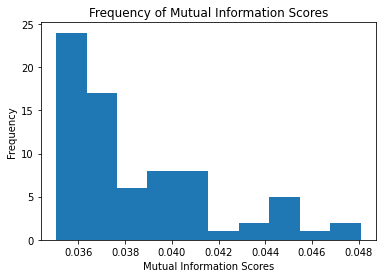

In [ ]:
# Use a histogram to show the frequency of the Mutual Information Scores
temp_arr = X_new.scores_
plt.hist(temp_arr[temp_arr>0.035])
plt.xlabel('Mutual Information Scores')
plt.ylabel('Frequency')
plt.title('Frequency of Mutual Information Scores')

In [ ]:
# Now select the best 10 features
X_new = SelectKBest(mutual_info_classif, k=10).fit(X, y)

In [ ]:
# Transform the features back into DataFrame format
kfeatures=X_new.fit_transform(X, y)
alt_df = pd.DataFrame(kfeatures)
alt_df['class']=class_id_list
alt_df['person']=person_id_list
alt_df['shot']=shot_id_list

# 6. Training and Testing CatBoost Models

In [ ]:
total_r = 0
total_success = 0
total_failure = 0
results = []

# Get the 5 Fold Cross Validation train, test splits for the entire dataset
train_splits, test_splits = get_all_splits(alt_df,'all')

# Train and test the CatBoost models with 5 different partitions of the dataset
for i in range(0,5):
    predictor = TabularPredictor(label=label,path="/content/drive/My Drive/Senior Design C41/catboost_models/").fit(train_splits[i], hyperparameters={'CAT':{}},presets='best_quality')
    preds = predictor.predict(test_splits[i].drop(columns=[label]))

    total_r = total_r + classification_report(preds,test_splits[i][label],output_dict=True)['accuracy']*len(test_splits[i])
    temp_df = test_splits[i]

    total_success = total_success + classification_report(preds,test_splits[i][label],output_dict=True)['1']['recall']*len(temp_df[temp_df['class']==1])
    total_failure = total_failure + classification_report(preds,test_splits[i][label],output_dict=True)['0']['recall']*len(temp_df[temp_df['class']==0])

    results.append(classification_report(preds,test_splits[i][label],output_dict=True)['accuracy'])

In [ ]:
# Accuracy
total_r/len(flatten_df)

0.6715888954518606

In [ ]:
# Success Recall
total_success/len(flatten_df[flatten_df['class']==1])

0.6239534599345078

In [ ]:
# Failure Recall
total_failure/len(flatten_df[flatten_df['class']==0])

0.6756180854250953

In [ ]:
"""
Function for printing out recall rate information
  Inputs: classification_reports in dictionary format
  Output: Prints out recall rates
"""
def print_recall(reports):
    total_0 = 0
    total_1 = 0
    support_0 = 0
    support_1 = 0
    for i in range(0,5):
        total_0 = total_0 + reports[i]['0']['recall']*reports[i]['0']['support']
        total_1 = total_1 + reports[i]['1']['recall']*reports[i]['1']['support']
        support_0 = support_0 + reports[i]['0']['support']
        support_1 = support_1 + reports[i]['1']['support']
    print('Success Recall Rate: '+str(total_0/support_0))
    print('Failure Recall Rate: '+str(total_1/support_1))

In [ ]:
total_r = 0
results = []
reports = []

# Get the 5 Fold Cross Validation train, test splits for Justin
train_splits, test_splits = get_all_splits(alt_df,'justin')

for i in range(0,5):
    predictor = TabularPredictor(label=label).fit(train_splits[i], hyperparameters={'CAT':{}},presets='best_quality')
    preds = predictor.predict(test_splits[i].drop(columns=[label]))

    total_r = total_r + classification_report(preds,test_splits[i][label],output_dict=True)['accuracy']*len(test_splits[i])

    results.append(classification_report(preds,test_splits[i][label],output_dict=True)['accuracy'])
    reports.append(classification_report(preds,test_splits[i][label],output_dict=True))print_recall(reports)

In [ ]:
# Justin Model Accuracy
total_r/(len(train_splits[0])+len(test_splits[0]))

0.6807228915662651

In [ ]:
# Justin Model Recall Rates
print_recall(reports)

Success Recall Rate: 0.6818181818181818
Failure Recall Rate: 0.6428571428571429


In [ ]:
total_r = 0
results = []
reports = []

# Get the 5 Fold Cross Validation train, test splits for Brendan
train_splits, test_splits = get_all_splits(alt_df,'brendan')

for i in range(0,5):
    predictor = TabularPredictor(label=label).fit(train_splits[i], hyperparameters={'CAT':{}},presets='best_quality')
    preds = predictor.predict(test_splits[i].drop(columns=[label]))

    total_r = total_r + classification_report(preds,test_splits[i][label],output_dict=True)['accuracy']*len(test_splits[i])

    results.append(classification_report(preds,test_splits[i][label],output_dict=True)['accuracy'])
    reports.append(classification_report(preds,test_splits[i][label],output_dict=True))

In [ ]:
# Brendan Model Accuracy
total_r/(len(train_splits[0])+len(test_splits[0]))

0.6943396226415094

In [ ]:
# Brendan Model Recall Rates
print_recall(reports)

Success Recall Rate: 0.6994219653179191
Failure Recall Rate: 0.45454545454545453


In [ ]:
total_r = 0
results = []
reports = []

# Get the 5 Fold Cross Validation train, test splits for Carl
train_splits, test_splits = get_all_splits(alt_df,'carl')

for i in range(0,5):
    predictor = TabularPredictor(label=label).fit(train_splits[i], hyperparameters={'CAT':{}},presets='best_quality')
    preds = predictor.predict(test_splits[i].drop(columns=[label]))

    total_r = total_r + classification_report(preds,test_splits[i][label],output_dict=True)['accuracy']*len(test_splits[i])

    results.append(classification_report(preds,test_splits[i][label],output_dict=True)['accuracy'])
    reports.append(classification_report(preds,test_splits[i][label],output_dict=True))

In [ ]:
# Carl Model Accuracy
total_r/(len(train_splits[0])+len(test_splits[0]))

0.6481203007518797

In [ ]:
# Carl Model Recall Rates
print_recall(reports)

Success Recall Rate: 0.6496478873239436
Failure Recall Rate: 0.6391752577319587


## Notes:
* Removing fingertips from data is bad as it will reduce the accuracy.